# Projeto Covid 19 (BR) - DIO/ UNIMED

# 1- Objetivo

## - Identificar a evolução da covid-19 no Brasil

# 2- Bibliotecas

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import inflection
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from ipywidgets import IntProgress
from fbprophet import Prophet

In [4]:
#Ignore warning
warnings.filterwarnings('ignore')

# 3- Carga dos dados

In [5]:
# Criando do dataframe
#df = pd.read_csv('covid_19_data.csv', low_memory=False)
df_all = pd.read_csv('covid_19_data.csv')


# 4- Descricao dos dados

### 4.0.1- Overview Dataset

In [6]:
df_all.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [7]:
df_all.shape

(26713, 8)

In [8]:
df_all['Country/Region'].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

### 4.0.2- Selecionando o pais Br

In [9]:
# Selecionando o data set do Br
df = df_all.loc[ (df_all['Country/Region']=="Brazil") ]

In [10]:
# Copia do df
df1=df.copy()

In [11]:
df1.shape

(85, 8)

In [12]:
# Calculo do percentual do Brasil no registro total da covid-19 do dataset
val_total= df_all.shape[0]
val_br=df1.shape[0]

quotient = val_br/val_total

print(f'Os registros do Brasil corresponde a {quotient*100:.2f}% em relacao ao registro total.')


Os registros do Brasil corresponde a 0.32% em relacao ao registro total.


## 4.1 - Renomenando as Colunas

In [13]:
df1.columns

Index(['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered'],
      dtype='object')

In [14]:
#convertendo a label das colunas em snake case
df1.columns= ['sno', 'observation_date', 'province_state', 'country_region', 'last_update', 'confirmed', 'deaths', 'recovered']

In [15]:
df1.columns

Index(['sno', 'observation_date', 'province_state', 'country_region',
       'last_update', 'confirmed', 'deaths', 'recovered'],
      dtype='object')

## 4.2- Dimensão do Dataset

In [16]:
# Dimensao do dataset
print('Total de linhas: {}'.format(df1.shape[0]))
print('Total de colunas: {}'.format(df1.shape[1]))

Total de linhas: 85
Total de colunas: 8


## 4.3- Tipo dos Dados

In [17]:
# Tipo dos dados
df1.dtypes

sno                   int64
observation_date     object
province_state       object
country_region       object
last_update          object
confirmed           float64
deaths              float64
recovered           float64
dtype: object

In [18]:
# Atualizando as colunas Observation Date e Last update para o formato datatime
df1['observation_date']=pd.to_datetime(df1['observation_date'])

#df1['last_update']=pd.to_datetime(df1['last_update'])
df1['last_update']=pd.to_datetime(df1['last_update']).dt.normalize() # removendo as horas


In [19]:
# Convertendo os campos para o formato Int
df1['confirmed']=df1['confirmed'].astype('int64')
df1['deaths']=df1['deaths'].astype('int64')
df1['recovered']=df1['recovered'].astype('int64')

In [20]:
df1.dtypes

sno                          int64
observation_date    datetime64[ns]
province_state              object
country_region              object
last_update         datetime64[ns]
confirmed                    int64
deaths                       int64
recovered                    int64
dtype: object

In [21]:
df1.head(5)

,sno,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered
82,83,2020-01-23,NaN,Brazil,2020-01-23,0,0,0
2455,2456,2020-02-26,NaN,Brazil,2020-02-26,1,0,0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26,1,0,0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26,1,0,0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29,2,0,0


## 4.4- Check NA

In [22]:
df1.isna().sum()

sno                  0
observation_date     0
province_state      85
country_region       0
last_update          0
confirmed            0
deaths               0
recovered            0
dtype: int64

## 4.5- Fill NA

#### Os registros do Brasil, não apresenta nenhum apontamento de valores das colunas "province_state",
#### Neste caso, ou se define um critério de preenchimento, ou ignoramos esta coluna.
#### Assumiremos que não utilizaremos as informações desta coluna na análise dos dados

In [23]:
df1.head(10)

,sno,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered
82,83,2020-01-23,NaN,Brazil,2020-01-23,0,0,0
2455,2456,2020-02-26,NaN,Brazil,2020-02-26,1,0,0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26,1,0,0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26,1,0,0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29,2,0,0
2903,2904,2020-03-01,NaN,Brazil,2020-02-29,2,0,0
3032,3033,2020-03-02,NaN,Brazil,2020-02-29,2,0,0
3173,3174,2020-03-03,NaN,Brazil,2020-02-29,2,0,0
3322,3323,2020-03-04,NaN,Brazil,2020-03-04,4,0,0
3486,3487,2020-03-05,NaN,Brazil,2020-03-04,4,0,0


## 4.6- Change Types

In [24]:
df1.dtypes

sno                          int64
observation_date    datetime64[ns]
province_state              object
country_region              object
last_update         datetime64[ns]
confirmed                    int64
deaths                       int64
recovered                    int64
dtype: object

## 4.7- Estatistica descritiva

### 4.7.1- Variaveis numericas

In [72]:
# Removendo o indice do dataset
df1=df1.drop(labels='sno', axis=1)

In [74]:
df1.head()

,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered
82,2020-01-23,NaN,Brazil,2020-01-23,0,0,0
2455,2020-02-26,NaN,Brazil,2020-02-26,1,0,0
2559,2020-02-27,NaN,Brazil,2020-02-26,1,0,0
2668,2020-02-28,NaN,Brazil,2020-02-26,1,0,0
2776,2020-02-29,NaN,Brazil,2020-02-29,2,0,0


In [75]:
# variaveis numericas
num_attributes = df1.select_dtypes(include=['int64', 'float64'])


In [76]:
num_attributes.sample(3)

,confirmed,deaths,recovered
24850,220291,14962,84970
18030,54043,3704,27655
7337,1021,15,2


In [81]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'] )


In [82]:
cat_attributes.sample(3)

,province_state,country_region
19629,NaN,Brazil
18349,NaN,Brazil
6755,NaN,Brazil


In [ ]:
# Metricas de Tendencia central -  Media , Mediana

In [83]:
# Formata casas decimais
pd.options.display.float_format = '{:20,.2f}'.format

In [84]:
ct_media = pd.DataFrame(num_attributes.apply( np.mean)).T
ct_mediana = pd.DataFrame(num_attributes.apply(np.median)).T

In [85]:
# Metrica de dispersao - Desvio padrao(std), min, max, range,skew, kurtosis

d_std = pd.DataFrame(num_attributes.apply(np.std)).T
d_min = pd.DataFrame(num_attributes.apply(min)).T
d_max = pd.DataFrame(num_attributes.apply(max)).T
d_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenando as metricas
metricas = pd.concat([ d_min, d_max, d_range, ct_media, ct_mediana, d_std, d_skew, d_kurtosis]).T.reset_index()

In [86]:
# Renomeando as colunas
#metricas = pd.concat([ d_min, d_max, d_range, ct_media, ct_mediana, d_std, d_skew, d_kurtosis]).T.reset_index()
metricas.columns=['Attributes', 'min', 'max','range', 'mean', 'median','std','skew','kurtosis']

In [87]:
metricas

,Attributes,min,max,range,mean,median,std,skew,kurtosis
0,confirmed,0.00,"271,885.00","271,885.00","50,495.58","14,034.00","71,447.27",1.57,1.48
1,deaths,0.00,"17,983.00","17,983.00","3,359.78",686.00,"4,873.38",1.53,1.25
2,recovered,0.00,"106,794.00","106,794.00","19,808.78",127.00,"29,072.26",1.40,0.93


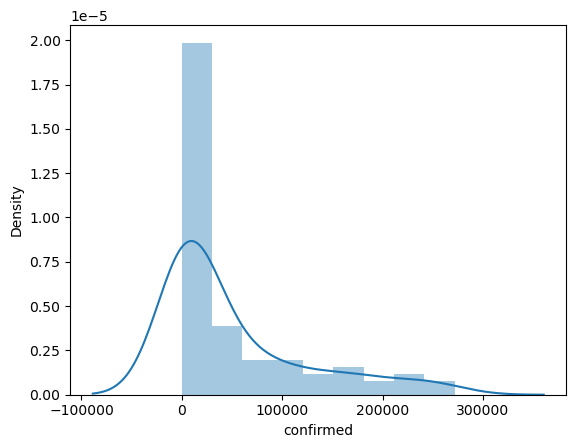

In [88]:
sns.distplot(df1['confirmed']);

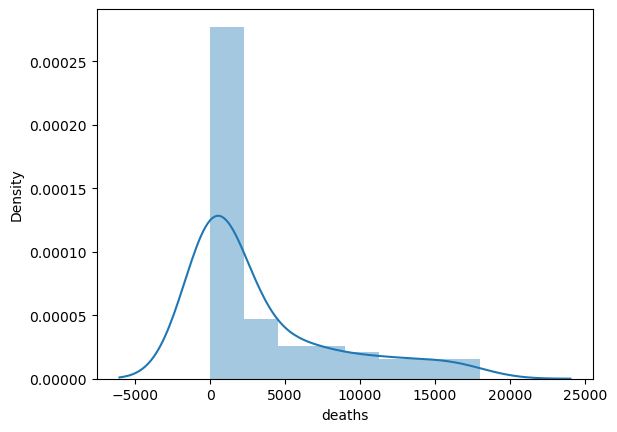

In [35]:
sns.distplot(df1['deaths']);

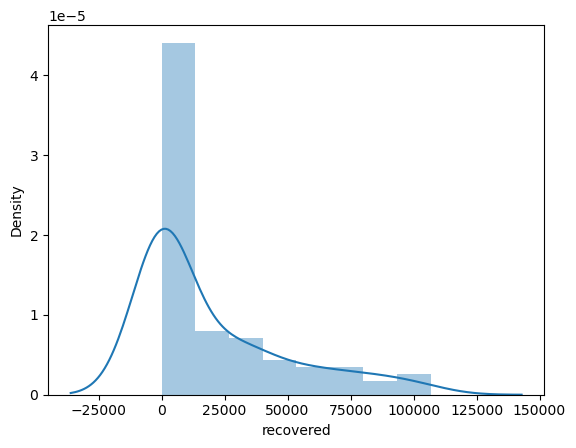

In [89]:
sns.distplot(df1['recovered']);

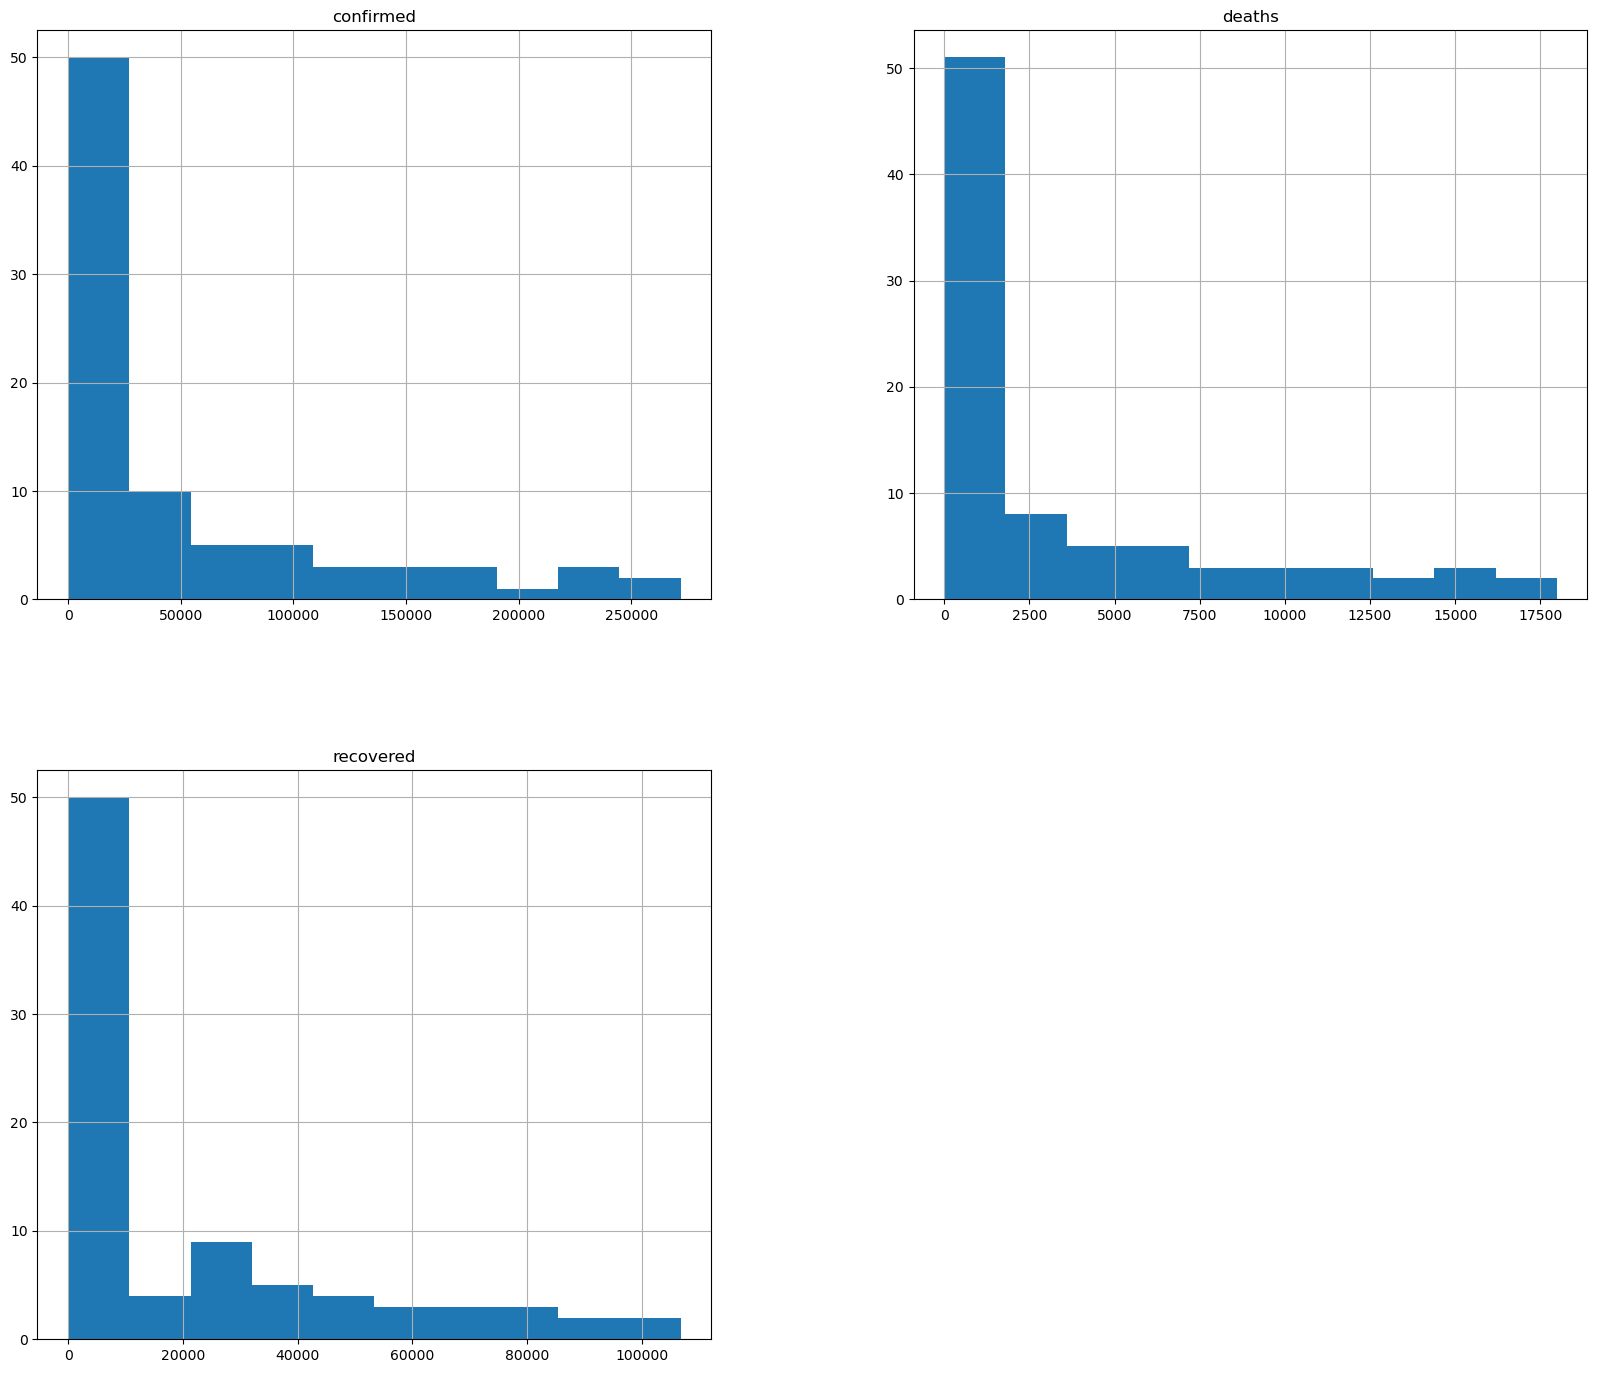

In [113]:
# Histograma
num_attributes.hist(bins = 10, figsize = (20,17));

### 4.7.2- Variaveis categoricas 

In [91]:
cat_attributes.apply( lambda x: x.unique().shape[0])

province_state    1
country_region    1
dtype: int64

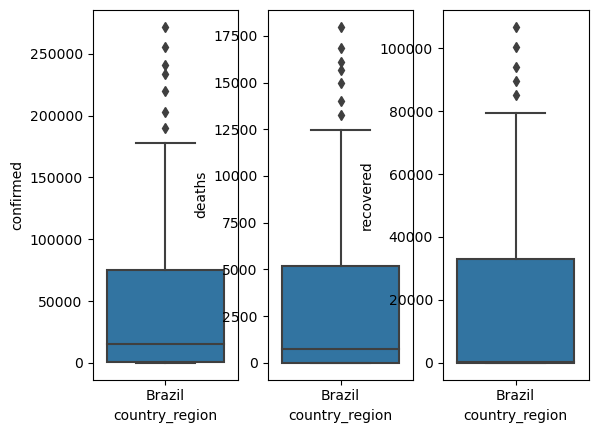

In [92]:
aux_1=df1[ (df1['confirmed']>0 ) ]

#confirmed
plt.subplot(1,3,1) 
sns.boxplot( x='country_region', y='confirmed',data=aux_1 )

#death
plt.subplot(1,3,2)
sns.boxplot( x='country_region', y='deaths',data=aux_1 )

#recovered
plt.subplot(1,3,3)
sns.boxplot( x='country_region', y='recovered',data=aux_1 );



# 5- Casos confirmados

In [93]:
df2 = df1.copy()

In [94]:
df2.head()

,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered
82,2020-01-23,NaN,Brazil,2020-01-23,0,0,0
2455,2020-02-26,NaN,Brazil,2020-02-26,1,0,0
2559,2020-02-27,NaN,Brazil,2020-02-26,1,0,0
2668,2020-02-28,NaN,Brazil,2020-02-26,1,0,0
2776,2020-02-29,NaN,Brazil,2020-02-29,2,0,0


In [95]:
px.line(df2, x='observation_date', y='confirmed', title="Brazil - Confirmed cases")


### Novos casos por dia

In [96]:
# Criando nova coluna para novos casos
df2['new_event'] = list(map(
        lambda x:0 if (x==0) else df2['confirmed'].iloc[x] - df2['confirmed'].iloc[x-1],
        np.arange(df2.shape[0])))

In [43]:
px.line(df2, 'observation_date', 'new_event', title="New event per day")

# 6- Mortes

In [97]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df2['observation_date'], y=df2['deaths'], 
               name="Deaths", mode='lines+markers', line={'color':'red'}))

fig.update_layout(title="Covid-19 Deaths in Brazil",
                  xaxis_title="Date",
                  yaxis_title="Number of deaths")
fig.show()


# 7- Taxa de crescimento medio
### taxa_crescimento = (presente/passado)**(1/n)-1

In [98]:
# Calculo da tx de crescimento
def taxa_crescimento(data, variable, start_dt=None, end_dt=None):
    # Se data inicio for None, define como a primeira data disponivel
    if start_dt == None:
        start_dt = data.observation_date.loc[data[variable] >0].min()
    else:
        start_dt=pd.to_datetime( start_dt )
    
    if end_dt == None:
        end_dt = data.observation_date.iloc[-1]
    else:
        end_dt = pd.to_datetime(end_dt)
        
    # Define os valores do presente e passado
    passado = data.loc[data.observation_date == start_dt, variable].values[0]
    presente= data.loc[data.observation_date == end_dt, variable].values[0]
    
    # Define o numero de pontos no tempo q vamos avaliar
    n = (end_dt - start_dt).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n)-1
    
    return taxa*100

# Taxa de crescimento medio do covid no breasil por periodo
tx_crescimento = taxa_crescimento( df2, 'confirmed')

print(f"A taxa de crescimento, no periodo, foi de {tx_crescimento.round(2)}%.")


A taxa de crescimento, no periodo, foi de 16.27%.


# 8- Taxa de crescimento diario

In [99]:
def taxa_crescimento_diario(data, variable, start_dt=None):
    # Se data de inicio for None, define como a primeira data disponivel
    if start_dt == None:
        start_dt = data.observation_date.loc[data[variable] > 0].min()
    else:
        start_dt = pd.to_datetime(start_dt)
        
    end_dt = data.observation_date.max()
    # Define o numero de pontos no tempo q vamos avaliar
    n = (end_dt - start_dt).days
    
    # Taxa calculada de um dia para outro
    taxas = list(map(
          lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
                 range(1, n+1)
                ))
    return np.array(taxas) * 100

tx_dia = taxa_crescimento_diario(df2, 'confirmed')
tx_dia

array([         inf,   0.        ,   0.        , 100.        ,
         0.        ,   0.        ,   0.        , 100.        ,
         0.        , 225.        ,   0.        ,  53.84615385,
        25.        ,  24.        ,  22.58064516,  36.84210526,
       190.38461538,   0.        ,   7.28476821,  23.45679012,
        60.5       ,  15.88785047,  66.93548387,  27.69726248,
        28.75157629,  51.4201763 ,  24.45019405,  16.78794179,
        13.66266133,  16.87548943,  14.47236181,  14.25226807,
         9.01639344,   7.58928571,  24.8525879 ,  19.57320273,
        17.67115272,  12.58080557,  14.39929329,   7.43243243,
         9.26325247,  15.40169394,  15.22017956,  11.88620903,
         8.54521335,   5.54537122,   7.06807546,   5.57858688,
         7.81903542,  12.10513815,   7.4329096 ,  10.70501233,
         8.83557983,   5.44492335,   5.4043566 ,   5.73350023,
         6.21648599,   9.35157462,   8.00823407,   9.77184834,
         6.36504619,   6.88748019,   8.58316283,   8.80

In [47]:
primeiro_dia = df2['observation_date'].loc[df2['confirmed'] > 0].min()

px.line(x=pd.date_range(primeiro_dia, df2['observation_date'].max())[1:],
        y=tx_dia, title="Growth rating confirmed cases in Brazil ", 
        labels={'y':'Growth Rate', 'x':'Date'})

# 9- Modelo de Machine Learning

## 9.1- Predicoes

In [100]:
new_case = df2['new_event']
new_case.index = df2['observation_date']


In [49]:
df2['observation_date'].unique()

array(['2020-01-23T00:00:00.000000000', '2020-02-26T00:00:00.000000000',
       '2020-02-27T00:00:00.000000000', '2020-02-28T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-03-02T00:00:00.000000000', '2020-03-03T00:00:00.000000000',
       '2020-03-04T00:00:00.000000000', '2020-03-05T00:00:00.000000000',
       '2020-03-06T00:00:00.000000000', '2020-03-07T00:00:00.000000000',
       '2020-03-08T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
       '2020-03-10T00:00:00.000000000', '2020-03-11T00:00:00.000000000',
       '2020-03-12T00:00:00.000000000', '2020-03-13T00:00:00.000000000',
       '2020-03-14T00:00:00.000000000', '2020-03-15T00:00:00.000000000',
       '2020-03-16T00:00:00.000000000', '2020-03-17T00:00:00.000000000',
       '2020-03-18T00:00:00.000000000', '2020-03-19T00:00:00.000000000',
       '2020-03-20T00:00:00.000000000', '2020-03-21T00:00:00.000000000',
       '2020-03-22T00:00:00.000000000', '2020-03-23

## 9.2- Decomposicao 

In [101]:
# Realizando a decomposicao para melhor visualizacao
res = seasonal_decompose(new_case, period=6)


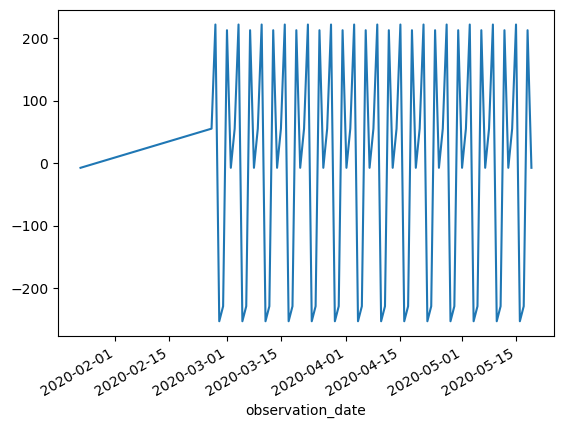

In [52]:
res.seasonal.plot();

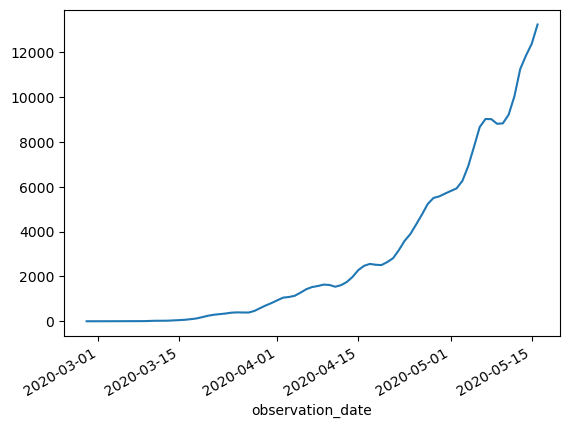

In [102]:
res.trend.plot();

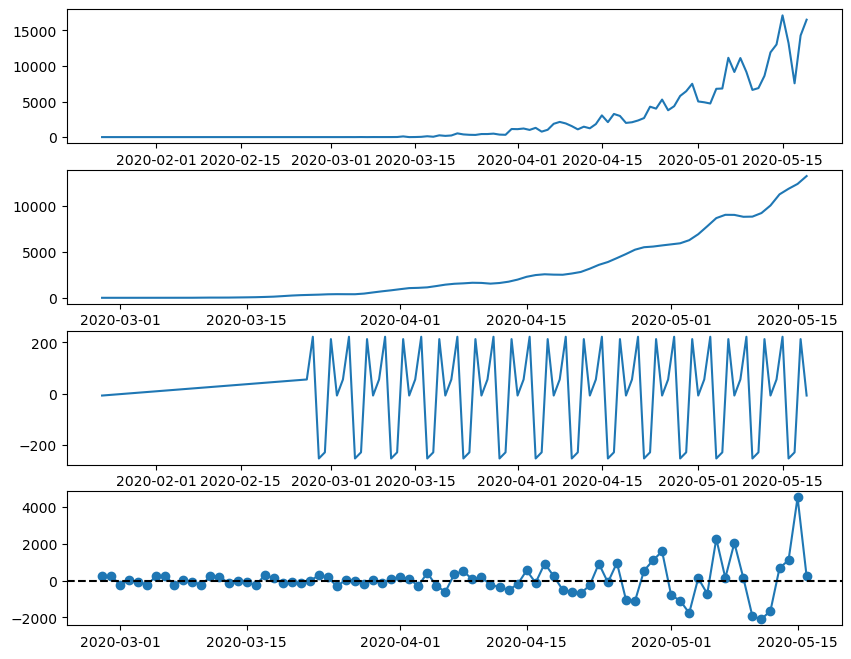

In [103]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,8 ))

ax1.plot(res.observed)  # Original
ax2.plot(res.trend)     # Tendencia
ax3.plot(res.seasonal)  # Sazonalidade
ax4.plot(new_case.index, res.resid) # Residual
ax4.scatter(df2['observation_date'], res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show();


## 09.3- Previsao de casos confirmado como o modelo ARIMA

In [104]:
modelo = auto_arima(new_case)

In [105]:
#pd.date_range('2020-05-01', '2020-05-19')
pd.date_range('2020-01-01', '2020-06-23')

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-06-14', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19', '2020-06-20', '2020-06-21',
               '2020-06-22', '2020-06-23'],
              dtype='datetime64[ns]', length=175, freq='D')

In [58]:
fig = go.Figure(go.Scatter( x=new_case.index, y=new_case, name="Observed" ))

fig.add_trace(go.Scatter( x=new_case.index, y = modelo.predict_in_sample(), name="Predicted" ))

#fig.add_trace(go.Scatter( x=pd.date_range('2020-05-20', '2020-06-05'), y=modelo.predict(15), name="Forecast" ))

fig.add_trace(go.Scatter( x=pd.date_range('2020-05-20', '2020-06-30'), y=modelo.predict(30), name="Forecast" ))

fig.update_layout(title="Forecast confirmed event for next 30 days.", yaxis_title="Confirmed Event", xaxis_title="Date")
fig.show()




## 09.4- Forecasting com Facebook Prophet

In [106]:
df2.observation_date

82      2020-01-23
2455    2020-02-26
2559    2020-02-27
2668    2020-02-28
2776    2020-02-29
           ...    
24850   2020-05-15
25227   2020-05-16
25604   2020-05-17
25981   2020-05-18
26358   2020-05-19
Name: observation_date, Length: 85, dtype: datetime64[ns]

In [107]:
df3=df2.copy()

In [108]:
df3.head()

,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered,new_event
82,2020-01-23,NaN,Brazil,2020-01-23,0,0,0,0
2455,2020-02-26,NaN,Brazil,2020-02-26,1,0,0,1
2559,2020-02-27,NaN,Brazil,2020-02-26,1,0,0,0
2668,2020-02-28,NaN,Brazil,2020-02-26,1,0,0,0
2776,2020-02-29,NaN,Brazil,2020-02-29,2,0,0,1


In [109]:
new_case_1 = df3['new_event']
new_case_1.index = df3['observation_date']

In [63]:
# Preprocessamentos
train = new_case_1.reset_index()[:-5]
test = new_case_1.reset_index()[-5:]

# Renomenado Colunas
train.rename(columns={'observation_date':'ds', 'new_event':'y'}, inplace=True)
test.rename(columns={'observation_date':'ds', 'new_event':'y'}, inplace=True)

test = test.set_index('ds')
test = test['y']

# Definir o modelo de crescimento
profeta = Prophet(growth='logistic', changepoints=["2020-03-21", "2020-03-30", "2020-04-25", "2020-05-03", "2020-05-10"])
#profeta = Prophet(growth='logistic', changepoints=["2020-04-30", "2020-05-20", "2020-05-08", "2020-05-10", "2020-05-15"])

#pop = 1000000
#pop = 211463256 #https://www.ibge.gov.br/apps/populacao/projecao/box_popclock.php
pop =211463256
train['cap'] = pop

#treina o modelo
profeta.fit(train)

#Construir previsoes para o futuro
future_dates = profeta.make_future_dataframe(periods=200)
future_dates['cap']=pop
forecast = profeta.predict(future_dates)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [110]:
fig=go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name="Forecast"))
fig.add_trace(go.Scatter(x=test.index, y=test, name="Observed - Test"))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name="Observed - Train"))
fig.update_layout(title="Confirmed Forecast event in Brazil")
fig.show()

# 10- Conclusao

### <font color="1318A3"> Apesar de representar 0,32% do total geral das amostras, Os modelos Arima e Prophet, sugerem o crescimento acentuado da infecção dos pacientes pela Covid-19. </font> 